In [1]:
from lisa.utils import *
from lisa.library import *
import lisa.models
import numpy as np, pandas as pd, datetime
from matplotlib import pyplot as plt, style # for ploting
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools

In [20]:
style.use('ggplot')
np.random.seed(42) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.binary):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
datastream = DataSet.objects.get(id=6)
df = datastream.dataframe
print(df.shape)
df_res = pd.DataFrame(index=df.index, columns=df.columns)
df_mean = df.mean(axis=1)
df_std = df.std(axis=1)
df_quantile_25 = df.quantile(0.25, axis=1)
df_quantile_75 = df.quantile(0.75, axis=1)

(2016, 14)


In [4]:
count=0
for index, row in df.iterrows():
    for column in df.columns:
        IQR = df_quantile_75[index] - df_quantile_25[index]
        
        if row[column] < (df_quantile_25[index] - (1.5 * IQR)) or row[column] > (df_quantile_75[index] + (1.5 * IQR)):
            df_res.loc[index, column] = 1
            count+=1
            #print(index)
            #print('Val:', np.abs(row[column]))
            #print('Mean:', df_mean[index])
            #print('2 Std:', 2*df_std[index])
print(count)
print(df_res.sum(axis=0))

287
station
23      9.0
24     13.0
25     13.0
26      NaN
27     70.0
28      NaN
29     34.0
30      NaN
31      NaN
32      NaN
33      NaN
34      NaN
35    148.0
37      NaN
dtype: float64


In [5]:
indexes = []
for index, row in df_res.iterrows():
    for column in df_res.columns:
        if row[column] == 1:
            indexes.append(index)
            break
print(len(indexes))

222


In [6]:
df_class = pd.DataFrame(index=df.index)
df_class['Class'] = 0

for index in indexes:
    df_class.loc[index,'Class'] = 1
df = df.join(df_class)

In [7]:
normal = df[df['Class'] == 0]
anomaly = df[df['Class'] == 1]

In [8]:
from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.5, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Class'].mean())

Train shape:  (897, 15)
Proportion os anomaly in training set: 0.00

Valid shape:  (559, 15)
Proportion os anomaly in validation set: 0.20

Test shape:,  (560, 15)
Proportion os anomaly in test set: 0.20



In [9]:
from sklearn.ensemble import IsolationForest
np.random.seed(42)

model = IsolationForest(random_state=42, n_jobs=4, max_samples=train.shape[0], bootstrap=True, n_estimators=50)
model.fit(train.drop('Class', axis=1).values)
print(model.decision_function(valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
print(model.decision_function(valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())

0.0152562735439
-0.0105319782551


In [13]:
tresholds = np.linspace(-.05, .05, 200)
y_scores = model.decision_function(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                   precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                   fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=1)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.44776119403 120


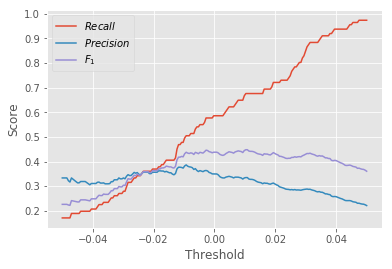

In [14]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_1$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: 0.010
Test Recall Score: 0.640
Test Precision Score: 0.194
Test F1 Score: 0.298


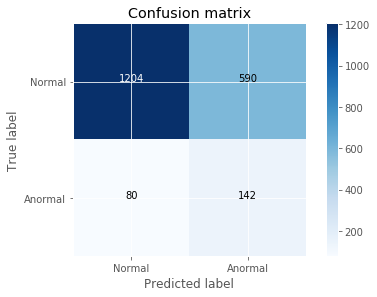

In [19]:
final_tresh = tresholds[scores[:, 2].argmax()]
df_n = df.reset_index(drop=True)
y_hat_test = (model.decision_function(df_n.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %.3f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('Test F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=df_n['Class'].values, beta=1))

cnf_matrix = confusion_matrix(df_n['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

Final threshold: 0.010
Recall Score: 0.640
Precision Score: 0.194
F1 Score: 0.298


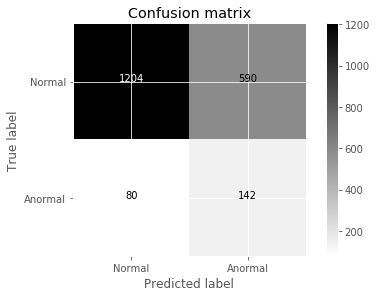

In [22]:
final_tresh = tresholds[scores[:, 2].argmax()]
df_n = df.reset_index(drop=True)
y_hat_test = (model.decision_function(df_n.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %.3f' % final_tresh)
print('Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=df_n['Class'].values, beta=1))

cnf_matrix = confusion_matrix(df_n['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')